ワークフローは一連のサブステップで構成されている。多くのビジネスプロセスは一連のドキュメント変換として考えられる。

ビジネスプロセスを表すパイプラインを作成し、それをさらに小さなパイプの集合体として構築する。そのようなプログラミングスタイルは
**変換指向プログラミング** と呼ばれることもある。

## 7.1 ワークフローの入力

ワークフローへの入力は常にドメインオブジェクトでなければならない（ただし意味論的にプリミティブ型であるなどの場合はある）

In [1]:
type Undefined = exn

type UnvalidatedCustomerInfo = Undefined
type UnvalidatedAddress = Undefined

// ドメインオブジェクト
type UnvalidatedOrder = {
    OrderId : string
    CustomerInfo : UnvalidatedCustomerInfo
    ShippingAddress : UnvalidatedAddress
}

// 注文書は厳密には（メタデータと共に）コマンドに内包され、コマンドがワークフローの入力となる
type PlaceOrder = {
    Order : UnvalidatedOrder
    TImestamp : DateTime
    UserId : string
    // ...
}

// コマンドの抽象型。 OOP における基底クラスと同様の役割を果たす
type Command<'data> = {
    Data : 'data
    TImestamp : DateTime
    UserId : string
    // ...
}

type PlaceOderAlt = Command<UnvalidatedOrder>
type ChangeOrder = Command<Undefined>
type CancelOrder = Command<Undefined>

// メッセージキューなど、単一の方法でコマンドが送信されることがあるので、データ構造を1つに統一する. この選択型は DTO にマッピングされる
type OrderTakingCommand =
    | Place of PlaceOrder
    | Change of ChangeOrder
    | Cancel of CancelOrder

The below script needs to be able to find the current output cell; this is an easy method to get it.

## 7.2 状態の集合による注文のモデリング（型による状態の表現）

In [2]:
type OrderId = OrderId of string // 単純型として定義することにする
type BillingAmount = BillingAmount of int

// トップレベルの型を定義
type CustomerInfo =
    | UnvalidatedCustomerInfo

type Address = Address of string

type ValidatedOrderLine = ValidatedOrderLine of Undefined
type PricedOrderLine = PricedOrderLine of Undefined

type OrderLine =
    | ValidatedOrderLine
    | PricedOrderLine

type UnvalidatedOrder = Undefined

type ValidatedOrder = {
    OrderId : OrderId
    CustomerInfo : CustomerInfo
    ShippingAddress : Address
    BillingAddress : Address
    OrderLines : ValidatedOrderLine list
}

type PricedOrder = {
    OrderId : OrderId
    CustomerInfo : CustomerInfo
    ShippingAddress : Address
    BillingAddress : Address
    OrderLines : PricedOrderLine list // 検証済みの注文明細行とは異なる
    AmountToBill : BillingAmount
}

// 状態を選択型で表す
type Order =
    | Unvalidated of UnvalidatedOrder
    | Validated of ValidatedOrder
    | Priced of PricedOrder

## 7.3 ステートマシン

ステートマシンとしてモデリングすることで、

* それぞれの状態において受け付ける処理を変えられる
* 全ての状態が明示的に文書化される
* 起こりうる状況を全て考慮に入れて設計するように強く促される

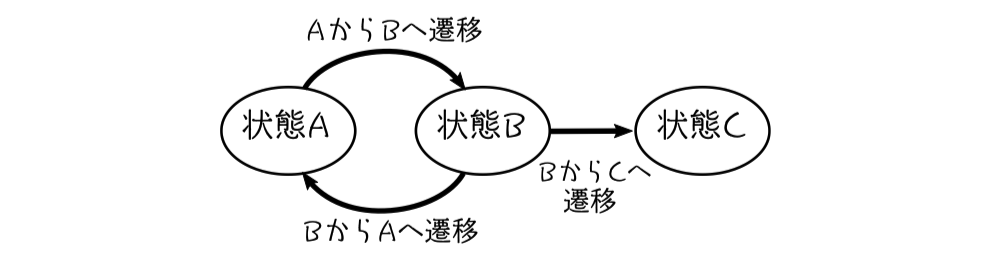

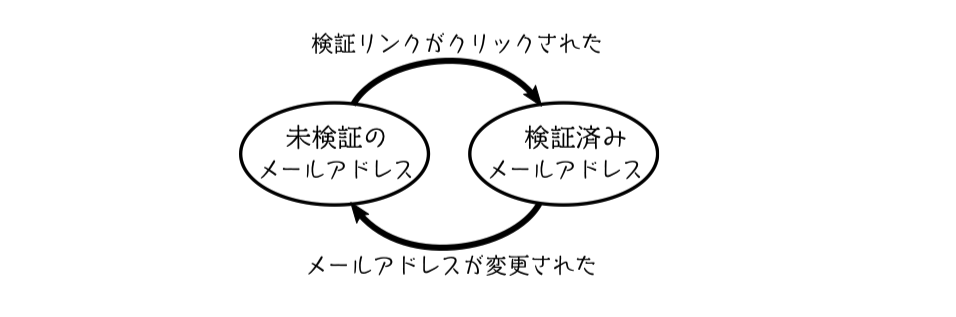

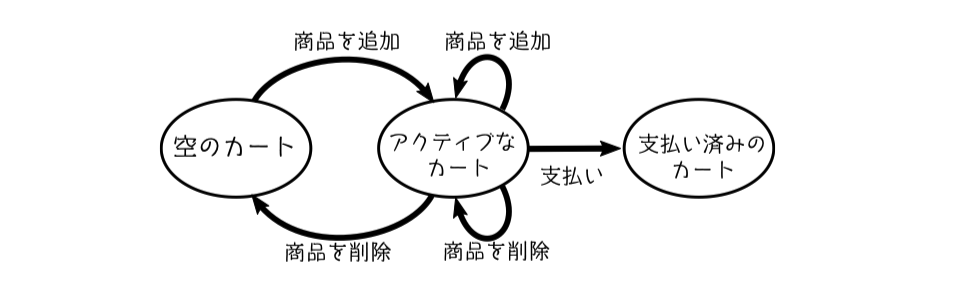

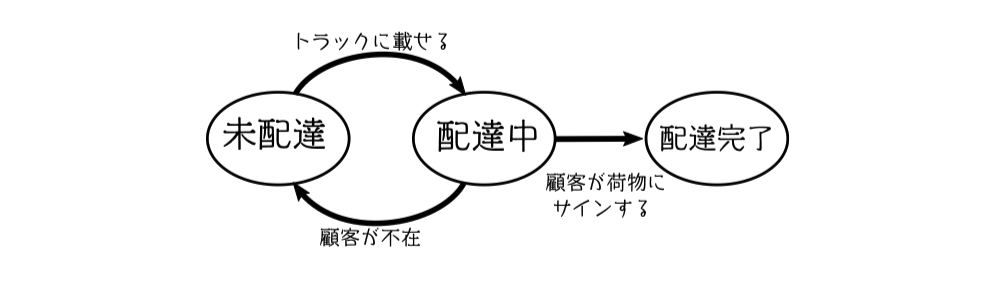

In [3]:
type Item = {
    OrderId: OrderId
}

type ActiveCartData = { UnpaidItems: Item list }
type PaidCartData = { PaidItems: Item list; Payment: float }

type ShoppingCart =
    | EmptyCart
    | ActiveCart of ActiveCartData
    | PaidCart of PaidCartData

let addItem cart item =
    match cart with
    | EmptyCart ->
        // create a new ActiveCart from specified item
        ActiveCart {UnpaidItems=[item]}
    | ActiveCart {UnpaidItems=existingItems} ->
        // create a new ActiveCart from specified item and current items
        ActiveCart {UnpaidItems = item :: existingItems}
    | PaidCart _ ->
        // ignore
        cart

let makePayment cart payment =
    match cart with
    | EmptyCart ->
        // ignore
        cart
    | ActiveCart {UnpaidItems=existingItems} ->
        // create a new PaidCart from specified payment method
        PaidCart {PaidItems = existingItems; Payment=payment}
    | PaidCart _ ->
        // ignore
        cart

## 7.4 型を使ったワークフローの各ステップのモデリング

「注文の検証」サブステップは以下のように文章化されている。

```
substep "ValidateOrder" =
    input: UnvalidatedOrder
    output: ValidatedOrder OR ValidationError
    dependencies: CheckProductCodeExists, CheckAddressExists
```

ここには依存関係が示されているが、これをどのようにコードにするのかが課題。インターフェースを使う。

In [4]:
type ValidationError = string

type ProductCode =
    | ProductCode of string
type ProductCodeAlt = ProducCode of string

// interface
type CheckProductCodeExists =
    ProductCode -> bool

// just a wrapped type of CheckedAddress for now
type CheckedAddress = CheckedAddress of UnvalidatedAddress

type AddressValidationError = AddressValidationError of string

// interface
type CheckAddressExists =
    UnvalidatedAddress -> Result<CheckedAddress, AddressValidationError>

// Substep definition
type ValidateOrder =
    CheckProductCodeExists // dependency
        -> CheckAddressExists // dependency
        -> UnvalidatedOrder // input
        -> Result<ValidatedOrder, ValidationError> // output

次に「価格計算」ステップの設計:

```
substep "PriceOrder" =
    input: ValidatedOrder
    output: PricedOrder
    dependencies: GetProductPrice
```

これは必ず成功するので Error を返す必要はない。

In [5]:
type Price = float

type GetProductPrice =
    ProductCode -> Price

type PriceOrder =
    GetProductPrice
        -> ValidatedOrder
        -> PricedOrder

次に注文書を作成してお客様に送信する。

```
service SendAcknowledgement =
    input: OrderAcknowledgement
    output: unit
```

In [6]:
type HtmlString = HtmlString of string
type EmailAddress = EmailAddress of string
type OrderAcknowledgementSent = Undefined

type OrderAcknowledgement = {
    EmailAddress : EmailAddress
    Lettter : HtmlString
    }

type CreateOrderAcknowledgmentLetter = PricedOrder -> HtmlString

type SendResult = Sent | NotSent

// Service interface
type SendOrderAcknowledgementV1 =
    // OrderAcknowledgement -> unit // 1st try
    // OrderAcknowledgement -> bool // 2nd try
    OrderAcknowledgement -> SendResult // final
    // OrderAcknowledgementSent option // returns optional event, as an idea

type OrderPlaced = PricedOrder
type BillableOrderPlaced = {
    OrderId : OrderId
    BillingAddress : Address
    AmountToBill : BillingAmount
    }

// idea. It would be difficult to change
// if the workflow (service) returns this.
type PlaceOrderResult = {
    OrderPlaced : OrderPlaced
    BillableOrderPlaced : BillableOrderPlaced
    OrderAcknowledgementSent : OrderAcknowledgementSent option
    }

// returns an event like this encaplulating every possible events
type PlaceOrderEvent =
    | OrderPlaced of OrderPlaced
    | BillableOrderPlaced of BillableOrderPlaced
    | AcknowledgementSent of OrderAcknowledgementSent

type CreateEvents =
    PricedOrder -> PlaceOrderEvent list

## 7.5 エフェクトの文書化 (副作用のコードへの表明)

エフェクト (副作用) とは、同じ入力なのに返ってくるデータが異なること。
`Async` 型である場合は外部プロセスにアクセスするためエフェクトがあることが多く（十分に信用度が高い場合は無視できる。失敗した場合は panic を起こしてプロセスを停止する）、 `Result` はエフェクトを意味する。

In [7]:
// 検証ステップでのエフェクト
type AsyncResult<'success,'failure> = Async<Result<'success,'failure>>

type CheckAddressExistsV2 =
    UnvalidatedAddress -> AsyncResult<CheckedAddress, AddressValidationError>

type ValidateOrder =
    CheckProductCodeExists      // dependency
        -> CheckAddressExistsV2 // dependency
        -> UnvalidatedOrder     // input
        -> AsyncResult<ValidatedOrder, ValidationError list> // output

// 価格設定ステップでのエフェクト
type PricingError = PricingError of string

type PriceOrder =
    GetProductPrice       // dependency
        -> ValidatedOrder // input
        -> Result<PricedOrder, PricingError>

// 確認ステップでのエフェクト
type SendOrderAcknowledgement =
    OrderAcknowledgement -> Async<SendResult> // assume always success

type AcknowledgeOrder =
    CreateOrderAcknowledgmentLetter // dependency
        -> SendOrderAcknowledgement  // Func returning Async
        -> PricedOrder               // input
        -> Async<OrderAcknowledgementSent option> // Asyncrounus output

## 7.6 ステップからワークフローの合成を試みる

各ステップを in/out だけ抜粋して順番に並べてみると、型が合わず、合成できないことがわかる。
合成するためには、値を「持ち上げる (Lift up)」したり、 bind/map する必要がある（後述）。

In [8]:
type ValidateOrderAlt =
    UnvalidatedOrder // input
        -> AsyncResult<ValidatedOrder, ValidationError> // output

type PriceOrderAlt =
    ValidatedOrder
        -> PricedOrder

type AcknowledgeOrderAlt =
    PricedOrder                                   // input
        -> Async<OrderAcknowledgementSent option> // Asyncrounus output

type CreateEventsAlt =
    PricedOrder -> PlaceOrderEvent list